# TextXD'18 hackathon: Analyze Scientific Papers in a Subject
- read a corpus = WOS
- clean up
- text representation: here word stems
- visualization

by Dani Ushizima and Alex Nascimento

In [1]:
#Data Wrangling
import pandas
import numpy as np
import os

import gensim #library needed for word2vec

#for visualization
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise
from sklearn.manifold import MDS, TSNE
import matplotlib.pyplot as plt

In [2]:
#Visualization parameters
%pylab inline
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [3]:
#read in all the data, with some cleaning
path ='../data/' #indicate the local path where files are stored
allFiles = os.listdir(path) #save the list of filenames into a variable
print(allFiles)
allFiles = ['New-Dataset.CSV']

['Dataset-clean.csv', 'New-Dataset.CSV', 'dani_mask.png']


In [4]:
list_ = []
files_ = []
for file_ in allFiles:
    filename = path+file_ #add the relative path name to the filename
    df = pandas.read_csv(filename, index_col=None, header=0)
    list_.append(df)
data = pandas.concat(list_).reset_index(drop=True)
#view the data
data.head(4)

,TI,DE,ID,AB,PY
0,Sustainability of construction materials: Elec...,Electrodialytic technology; Mortars production...,WASTE-WATER; CONCRETE; REMOVAL; SLUDGE,The reduction of tap water consumption in all ...,2019
1,An automatic and intelligent optimal surface m...,Tunnel structure; Point cloud; Likelihood meth...,LASER-SCANNING TECHNOLOGY; FINITE-ELEMENT MODE...,Automatically modeling and intelligently monit...,2019
2,Life cycle assessment for carbon dioxide emiss...,Life cycle assessment; Climate change; Carbon ...,GREENHOUSE-GAS EMISSIONS; QUANTITATIVE ASSESSM...,Carbon dioxide (CO2) emissions mitigation from...,2019
3,Green geopolymeric concrete using grits for ap...,Geopolymeric concrete; Biomass fly-ash; Grits;...,SUSTAINABILITY; TECHNOLOGY; INDUSTRY,This work investigates the production a green ...,2018


In [5]:
#Number of rows
data.shape

(2311, 5)

In [6]:
#View the first text
data['AB'][0]

'The reduction of tap water consumption in all activity sectors, including the building industry, is crucial to the sustainability of water resources. Effluents from wastewater treatment plants have the potential to replace freshwater in the construction sector but they contain a critical mixture of impurities, which hampers their use in mortars production. In this work, the viability of using effluent as an alternative to potable water for the production of mortars, after electrodialytic treatment, was assessed. Electrodialytic technology (ED-T) is a proven technique for decontamination of porous and aqueous matrices. ED-T experiments were conducted with 500 mL of effluent for 6, 12 and 24 h, with a current intensity of 25 mA. The results showed that after ED-T 6 h, the removal efficiencies of critical components were above 85% of their initial concentrations. Mortar properties such as setting time, workability, flexural strength, compressive strength and morphology were obtained for 

# Distiling vocabulary
- grab all abstracts
- stemmize and lemmatize
- frequency analysis

In [7]:
from nltk.tokenize import sent_tokenize, word_tokenize
#first sentence from wikipedia 
#data = "Concrete, usually Portland cement concrete, is a composite material composed of fine and coarse aggregate bonded together with a fluid cement (cement paste) that hardens over time—most frequently a lime-based cement binder, such as Portland cement, but sometimes with other hydraulic cements, such as a calcium aluminate cement. It is distinguished from other, non-cementitious types of concrete all binding some form of aggregate together, including asphalt concrete with a bitumen binder, which is frequently used for road surfaces, and polymer concretes that use polymers as a binder."
#tokens = word_tokenize(data['AB'][0])
#print(len(tokens))
#print(tokens)
abstracts = data.AB.str.cat(sep=' ')
#' '.join(data['AB'].astype())

In [8]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string 
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer


def preprocessing(text):
   
    # tokenize into words
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    
    # remove stopwords here might bring you headaches - put it last
    #stop = stopwords.words('english')
    #tokens = [token for token in tokens if token not in stop]
    
    # lower capitalization
    tokens = [word.lower() for word in tokens]

    # steemize
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens]
    
    # remove stopwords    
    cachedStopWords = set(stopwords.words('english'))
    #subsets
    newStopWords = ['that','usual','include','type','data', 'also']
    exclude = set(string.punctuation) 
    #adding to set
    cachedStopWords = cachedStopWords.union(newStopWords)
    cachedStopWords = cachedStopWords.union(exclude)
    tokens = [w for w in tokens if w not in cachedStopWords]
    
    # remove words less than three letters
    tokens = [word for word in tokens if len(word) >= 3]

    # lemmatize
    lmtzr = WordNetLemmatizer()
    tokens = [lmtzr.lemmatize(word) for word in tokens]
    preprocessed_text= ' '.join(tokens)
    
    return preprocessed_text 

In [9]:
#Better now with stems and lemmas
goodTokens = preprocessing(abstracts)

## Simple visualization

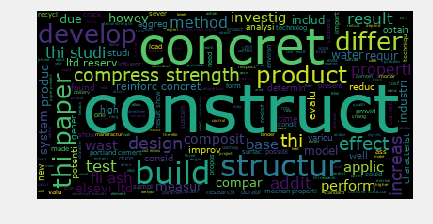

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 

text = 'all your base are belong to us all of your base base base'

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 1.0,
                          stopwords = {'use', 'right','one','two','materi','also','process'} # set or space-separated string
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(goodTokens)

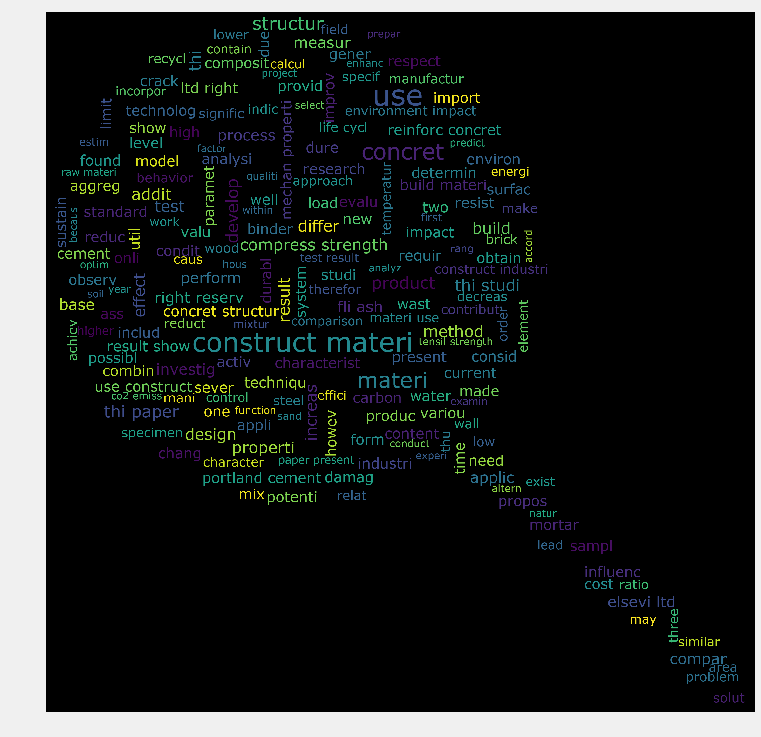

In [14]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    dani_mask = np.array(Image.open("../data/dani_mask.png"))
    wordcloud = WordCloud(
        font_path='/Library/Fonts/Verdana.ttf',
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1, # chosen at random by flipping a coin; it was heads
        mask=dani_mask,
    ).generate(str(data))

    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
show_wordcloud(goodTokens)

In [15]:
from nltk import FreqDist

def graph(f,n=30):
  tokens = word_tokenize(f)
  fd = FreqDist(tokens) 
  plt.figure(figsize=(30, 10))
  plt.rcParams.update({'font.size': 30})  
  plt.xlabel('lexicon', fontsize=20, fontweight='bold')
  plt.ylabel('Counts', fontsize=20, fontweight='bold')
  
  fd.plot(n,cumulative=False)

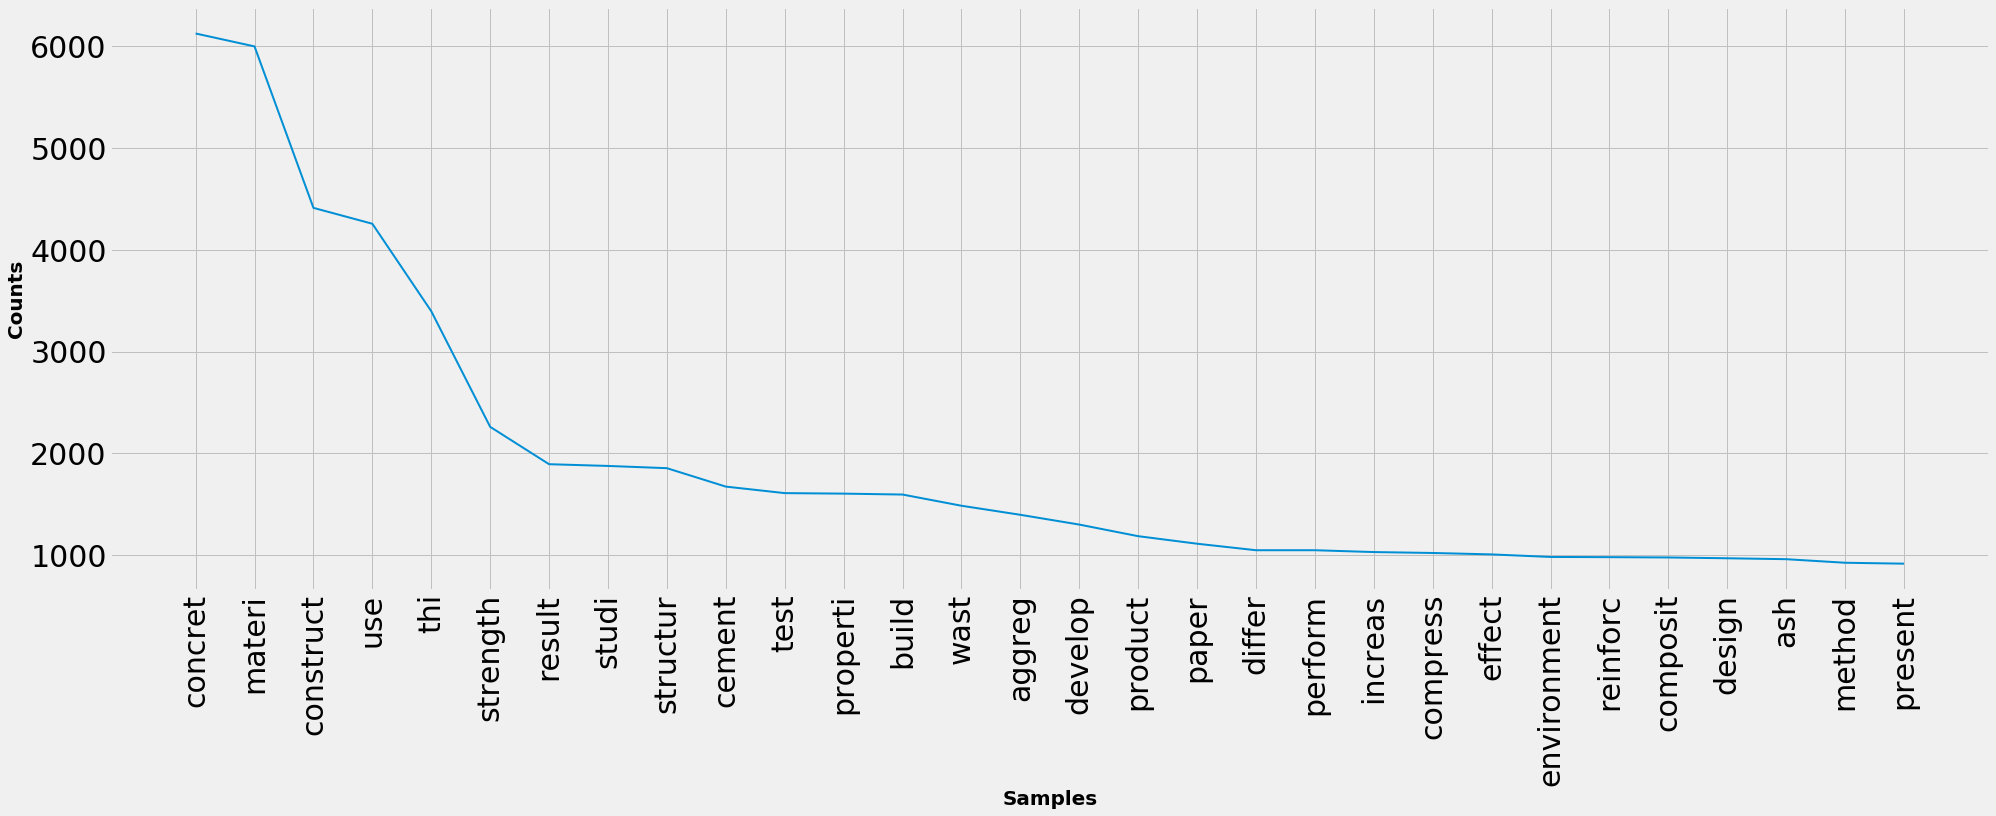

In [16]:
graph(goodTokens, 30)

In [17]:
import os
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
sns.set()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


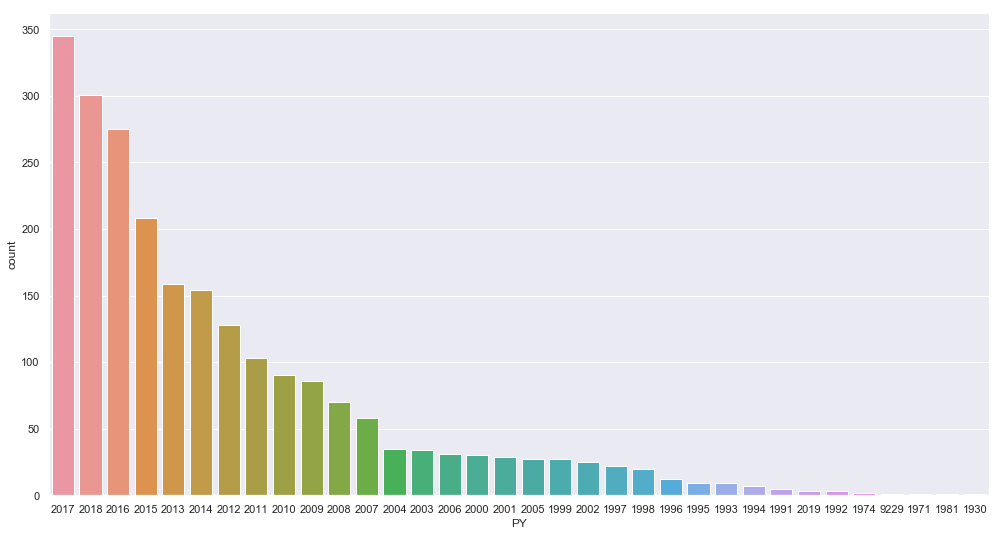

In [18]:
sns.set(rc={'figure.figsize':(15,8.27)})
sns.countplot(data['PY'], order=data['PY'].value_counts().index);

# Anything beyond frequency analysis around the lexicon?

1. **Word embedding**
2. topic modeling 
3. info vis for sumarization


In [52]:
data['tokens'] = data['AB'].str.split()
model = gensim.models.Word2Vec(data['tokens'].dropna(), size=100, window=5, \
                               min_count=1, sg=1, alpha=0.025, iter=50, batch_words=10000, workers=1)
#check other models at https://radimrehurek.com/gensim/models/word2vec.html

In [44]:
print('Length of vocabulary:',len(model.wv.vocab))

Length of vocabulary: 33090


In [45]:
type(data['tokens'][:10])

pandas.core.series.Series

In [46]:
data.AB.str.lstrip(string.punctuation)
print(data.AB.str.lstrip(string.punctuation))

0       The reduction of tap water consumption in all ...
1       Automatically modeling and intelligently monit...
2       Carbon dioxide (CO2) emissions mitigation from...
3       This work investigates the production a green ...
4       Replacing virgin materials with recycled or su...
5       The study describes an attributional life cycl...
6       In this work, a Rough Set Analysis-based appro...
7       According to the European Cement Association, ...
8       Since concrete is the most widely used constru...
9       Geopolymer is a cementitious material known fo...
10      The concrete production processes including ma...
11      This paper evaluates the suitability of stabil...
12      According to the National Building Code of Can...
13      Industrial wastes and recycled materials are b...
14      The strength gain of alkali-activated binders ...
15      3D printable construction materials need to be...
16      This review paper intends to synthesise the da...
17      Mixing

In [47]:
#Find the 10 most similar vectors to the given word vector, using cosine distance
model.wv.most_similar('limestone')

[('red', 0.9768992066383362),
 ('sintered', 0.968438982963562),
 ('replacements', 0.9650470018386841),
 ('reactive', 0.9649306535720825),
 ('binder,', 0.9643315076828003),
 ('pumice', 0.9635528326034546),
 ('metakaolin', 0.9631553292274475),
 ('oil-palm-boiler', 0.9620762467384338),
 ('PET', 0.9607049822807312),
 ('dune', 0.9604661464691162)]

In [48]:
model.wv.most_similar('environment')

[('pollution', 0.9312825798988342),
 ('burden', 0.9247092008590698),
 ('environment,', 0.9242788553237915),
 ('human', 0.9232454299926758),
 ('negative', 0.9221758842468262),
 ('minimize', 0.9139106273651123),
 ('savings', 0.9107235670089722),
 ('pollutants', 0.9101558923721313),
 ('harmful', 0.9091697931289673),
 ('costs,', 0.9081449508666992)]

In [49]:
model.wv.most_similar('sustainable')

[('environmentally', 0.925423800945282),
 ('search', 0.9221161603927612),
 ('green', 0.9105137586593628),
 ('friendly', 0.9089598655700684),
 ('eco-friendly', 0.9063977599143982),
 ('economical', 0.9020037651062012),
 ('greener', 0.9015617966651917),
 ('disposal.', 0.8911387324333191),
 ('challenge', 0.8893856406211853),
 ('development.', 0.8887351155281067)]

In [50]:
model.wv.most_similar('ash')

[('fly', 0.8804900646209717),
 ('bottom', 0.8702858090400696),
 ('coal', 0.8576502799987793),
 ('ashes', 0.8489137887954712),
 ('ash,', 0.842036247253418),
 ('Fly', 0.8409243226051331),
 ('ash.', 0.8405609130859375),
 ('combustion', 0.8376016616821289),
 ('(FA)', 0.8289912939071655),
 ('sludge', 0.8275811672210693)]

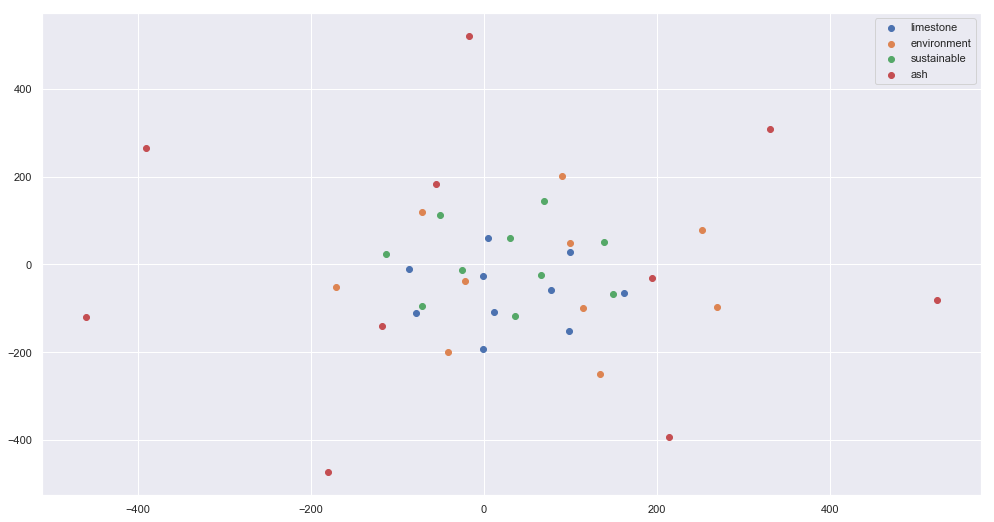

In [51]:
# Project similar words' word embedding to 2 dimension
from sklearn.manifold import TSNE

def plot_tsne(keywords):
    for key in keywords:
        X = np.array([model.wv.get_vector(word) for word, _ in model.wv.most_similar(key)])
        X_embed = TSNE(n_components=2).fit_transform(X)
        plt.scatter(X_embed[:, 0], X_embed[:, 1], label=key)
        plt.legend();
        

plot_tsne(['limestone', 'environment', 'sustainable', 'ash'])